In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(tf.__version__)


2.6.0


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print(" Install GPU version of TF")

Default GPU Device:/device:GPU:0


In [ ]:



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [ ]:
review_data= pd.read_csv("/content/drive/MyDrive/Soft Computing Project/Dataset.csv")
print(review_data.head(10))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

   Unnamed: 0      reviewerID  ... unixReviewTime   reviewTime
0           0  A30TL5EWN6DFXT  ...     1400630400  05 21, 2014
1           1   ASY55RVNIL0UD  ...     1389657600  01 14, 2014
2           2  A2TMXE2AFO7ONB  ...     1403740800  06 26, 2014
3           3   AWJ0WZQYMYFQ4  ...     1382313600  10 21, 2013
4           4   ATX7CZYFXI1KW  ...     1359849600   02 3, 2013
5           5   APX47D16JOP7H  ...     1381536000  10 12, 2013
6           6  A1JVVYYO7G56DS  ...     1377129600  08 22, 2013
7           7   A6FGO4TBZ3QFZ  ...     1384992000  11 21, 2013
8           8  A2JWEDW5FSVB0F  ...     1380067200  09 25, 2013
9           9   A8AJS1DW7L3JJ  ...     1396483200   04 3, 2014

[10 rows x 9 columns]
194226
Unique Products
10429
Unique Users
27879


In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))





-------Dataset --------
5.0    108496
4.0     39963
3.0     21434
1.0     13268
2.0     11059
Name: rating, dtype: int64
194220
-------------------------
Train Max Sentence Length :2932


In [ ]:
review_data['Num_words_text'].describe()

count    194220.000000
mean         44.937663
std          67.653843
min           0.000000
25%          14.000000
50%          23.000000
75%          49.000000
max        2932.000000
Name: Num_words_text, dtype: float64

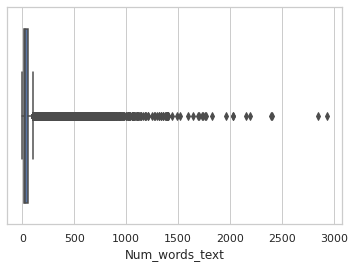

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

In [ ]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
90513
No of Long reviews
19885


In [ ]:
print(df_short_reviews['Num_words_text'].max())

99


In [ ]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

In [ ]:

filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)

test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())




105529
5.0    60985
4.0    20566
3.0    11243
1.0     7066
2.0     5669
Name: rating, dtype: int64
Train data
1    92794
0    12735
Name: sentiment, dtype: int64
139165
5.0    79579
4.0    27347
3.0    15056
1.0     9531
2.0     7652
Name: rating, dtype: int64
Test data
1    121982
0     17183
Name: sentiment, dtype: int64


In [ ]:
train_data['sentiment'].value_counts()

1    92794
0    12735
Name: sentiment, dtype: int64

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:52764
Class distributionCounter({1: 46397, 0: 6367})
Valid data len:52765
Class distributionCounter({1: 46397, 0: 6368})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['This is good.'])))

   


[[178, 1, 8]]


In [ ]:



x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=o

Train data len:52764
Class distributionCounter({1: 46397, 0: 6367})
Validation data len:52765
Class distributionCounter({1: 46397, 0: 6368})
Test data len:139165
Class distributionCounter({1: 121982, 0: 17183})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[   5  583   19 1322  809   12 3252  234   75   58 1059  595  432  134
 5274   19  139  155    4  155    4   32   61 3015  422    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[  121  6211   222 13517    47  3271   171    18    23     8    42    51
   166    18    38    77    65    80   434   144  1293   110    30    48
   305  1890   874   834   111   107  1516   226  8879   390    18   453
    18   808  4995   555   180   300  1554   926   547     3    26     2
    94    24     0     0     0     0     0     0     0    

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

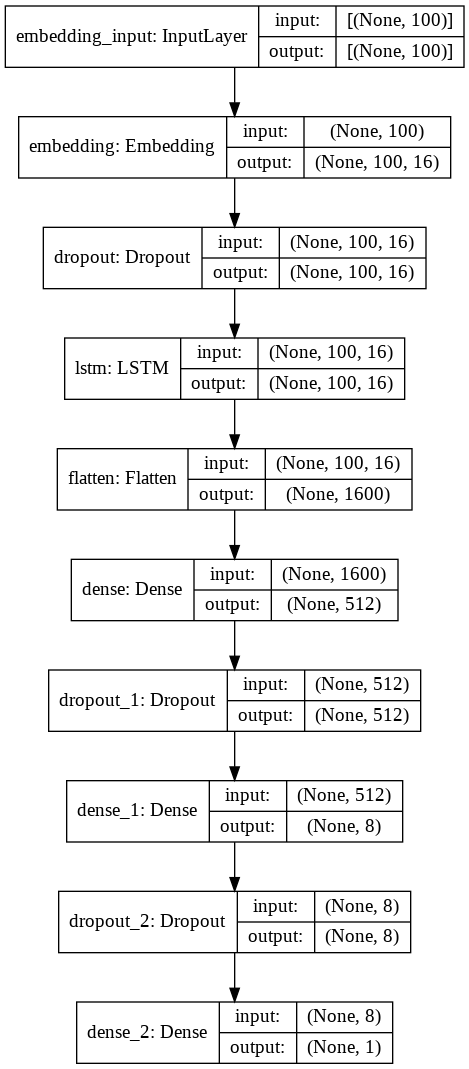

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochs = 10

history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
52/52 [==============================] - 38s 628ms/step - loss: 1.8687 - binary_accuracy: 0.8635 - val_loss: 0.6078 - val_binary_accuracy: 0.8793
Epoch 2/10
52/52 [==============================] - 32s 612ms/step - loss: 0.5688 - binary_accuracy: 0.8793 - val_loss: 0.4580 - val_binary_accuracy: 0.8793
Epoch 3/10
52/52 [==============================] - 32s 610ms/step - loss: 0.4599 - binary_accuracy: 0.8855 - val_loss: 0.3806 - val_binary_accuracy: 0.9034
Epoch 4/10
52/52 [==============================] - 32s 610ms/step - loss: 0.4204 - binary_accuracy: 0.9005 - val_loss: 0.3597 - val_binary_accuracy: 0.9072
Epoch 5/10
52/52 [==============================] - 32s 625ms/step - loss: 0.4081 - binary_accuracy: 0.9021 - val_loss: 0.3573 - val_binary_accuracy: 0.9033
Epoch 6/10
52/52 [==============================] - 32s 618ms/step - loss: 0.3912 - binary_accuracy: 0.9065 - val_loss: 0.3383 - val_binary_accuracy: 0.9095
Epoch 7/10
52/52 [==============================] - 33s 62

In [ ]:
history.history


{'binary_accuracy': [0.8635433316230774,
  0.879330575466156,
  0.8855090737342834,
  0.9004624485969543,
  0.9020923376083374,
  0.9065461158752441,
  0.907550573348999,
  0.9073421359062195,
  0.9079675674438477,
  0.9082897305488586],
 'loss': [1.868713140487671,
  0.5688010454177856,
  0.4599153995513916,
  0.42035943269729614,
  0.4081276059150696,
  0.3911849856376648,
  0.38144370913505554,
  0.3766902685165405,
  0.3688291311264038,
  0.37094101309776306],
 'val_binary_accuracy': [0.8793139457702637,
  0.8793139457702637,
  0.9033828973770142,
  0.9071922898292542,
  0.9032881855964661,
  0.9095233678817749,
  0.9079503417015076,
  0.9087652564048767,
  0.9084620475769043,
  0.9066237211227417],
 'val_loss': [0.6077558398246765,
  0.457960844039917,
  0.38058894872665405,
  0.35973870754241943,
  0.35728296637535095,
  0.3382889926433563,
  0.3457419276237488,
  0.3396380841732025,
  0.33871936798095703,
  0.3306768238544464]}

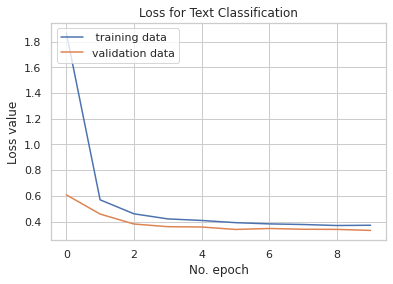

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

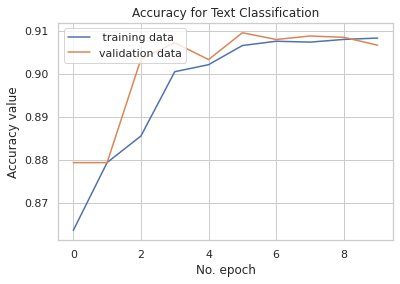

In [ ]:


plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [ ]:
model.save('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tf_lstmmodel.h5') 
json_string = tokenizer.to_json()


In [ ]:
import json
with open('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)
    

In [ ]:
valid_predict= model.predict(x_valid)

In [ ]:
print(valid_predict[:10])

[[0.8123149 ]
 [0.83566856]
 [0.99841   ]
 [0.99660987]
 [0.81370306]
 [0.97340864]
 [0.99756634]
 [0.99302894]
 [0.97741   ]
 [0.9532001 ]]


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

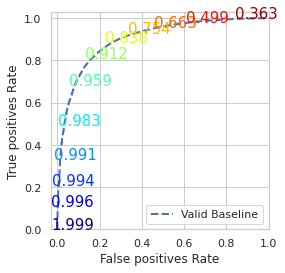

In [ ]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
new_model = tf.keras.models.load_model('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tf_lstmmodel.h5')
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [ ]:
with open('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:

print("Generate predictions for all samples")
predictions = new_model.predict(x_test)



Generate predictions for all samples


In [ ]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics   
from sklearn.metrics import f1_score
lebels=test_data['sentiment'].tolist()
pred_lebels=test_data['pred_sentiment'].tolist()

accuracy = accuracy_score(lebels, pred_lebels)
print('Accuracy: %f' % accuracy)

precision = precision_score(lebels, pred_lebels)
print('Precision: %f' % precision)

recall = recall_score(lebels, pred_lebels)
print('Recall: %f' % recall)

f1 = f1_score(lebels, pred_lebels)
print('F1 score: %f' % f1)

Accuracy: 0.892071
Precision: 0.956385
Recall: 0.918767
F1 score: 0.937198


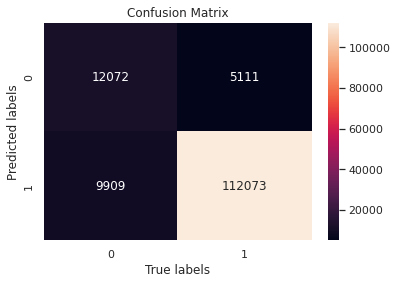

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics   
from sklearn.metrics import confusion_matrix 

ax= plt.subplot()

cm = confusion_matrix(lebels, pred_lebels)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  


ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.55      0.70      0.62     17183
           1       0.96      0.92      0.94    121982

    accuracy                           0.89    139165
   macro avg       0.75      0.81      0.78    139165
weighted avg       0.91      0.89      0.90    139165

